# General imports

In [14]:
import geopandas as gpd
import numpy as np
import pprint
import pyproj
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.neighbors import NearestNeighbors

from geograypher.cameras.derived_cameras import MetashapeCameraSet
from geograypher.cameras.segmentor import SegmentorPhotogrammetryCameraSet
from geograypher.meshes import TexturedPhotogrammetryMesh
from geograypher.predictors.derived_segmentors import LookUpSegmentor
from geograypher.utils.prediction_metrics import compute_and_show_cf, compute_comprehensive_metrics
from geograypher.utils.indexing import find_argmax_nonzero_value
from geograypher.utils.visualization import show_segmentation_labels
from geograypher.constants import (
    EXAMPLE_CAMERAS_FILENAME,
    EXAMPLE_MESH_FILENAME,
    EXAMPLE_IMAGE_FOLDER,
    EXAMPLE_PREDICTED_LABELS_FOLDER,
    EXAMPLE_DTM_FILE,
    EXAMPLE_AGGREGATED_FACE_LABELS_FILE,
    EXAMPLE_IDS_TO_LABELS,
    EXAMPLE_MESH_CRS,
    TEN_CLASS_VIS_KWARGS,
)

# Processing parameters

In [2]:
# Skip re-computing the aggregation and use a saved version
USE_CACHED_AGGREGATION = False
# Processing parameters
# HEIGHT_ABOVE_GROUND_THRESH = 2  # Height above the DTM to consider not ground
AGGREGATE_IMAGE_SCALE = 0.25  # Aggregate images at this scale resolution # TODOINVESTIGATE
# BUFFER_RADIUS_METER = 50  # Include cameras within this radius of labeled points # TODOINVESTIGATE

IDS_TO_LABELS = EXAMPLE_IDS_TO_LABELS # {0: 'ABCO', 1: 'CADE', 2: 'PILA', 3: 'PIPJ', 4: 'PSME', 5: 'SNAG'}
CAMERAS_FILENAME = EXAMPLE_CAMERAS_FILENAME # PosixPath('/ofo-share/repos-eric/geograypher/data/chips_tree_species/inputs/chips_cameras.xml')
MESH_FILENAME = EXAMPLE_MESH_FILENAME # PosixPath('/ofo-share/repos-eric/geograypher/data/chips_tree_species/inputs/chips_mesh_epsg3310_subset.ply')
MESH_CRS = EXAMPLE_MESH_CRS # 3310
# This is a nested (though presumably flat works too) set of original JPG images with 0-255
IMAGE_FOLDER = EXAMPLE_IMAGE_FOLDER # PosixPath('/ofo-share/repos-eric/geograypher/data/chips_tree_species/inputs/chips_images')
# This is a nested (though presumably flat works too) set of PNG images with 0-5 values
PREDICTED_IMAGE_LABELS_FOLDER = EXAMPLE_PREDICTED_LABELS_FOLDER # PosixPath('/ofo-share/repos-eric/geograypher/data/chips_tree_species/intermediate_results/image_predictions')
# # We use this to label the lowest parts as ground
# DTM_FILE = EXAMPLE_DTM_FILE # PosixPath('/ofo-share/repos-eric/geograypher/data/chips_tree_species/inputs/chips_DTM.tif')
# This is where we save labels (and also load them from cache)
AGGREGATED_FACE_LABELS_FILE = EXAMPLE_AGGREGATED_FACE_LABELS_FILE # PosixPath('/ofo-share/repos-eric/geograypher/data/chips_tree_species/intermediate_results/aggregated_face_labels.npy')

In [3]:
IDS_TO_LABELS = {0: "BO", 1: "CR", 2: "SH", 3: "HE", 4: "GR", 5: "LO", 6: "MA", 7: "SK"}
CAMERAS_FILENAME = Path("/ofo-share/scratch-eric/tmp/automate-test-360-st0077_SHIFT/automate-test-360-st0077_cameras.xml")
MESH_FILENAME = Path("/ofo-share/scratch-eric/tmp/automate-test-360-st0077_SHIFT/automate-test-360-st0077_mesh_0-1.ply")
MESH_CRS = 26910
IMAGE_FOLDER = Path("/ofo-share/repos-david/under-canopy-mapping/data/data_to_annotate/2024-ofo-gopro__st-0077-gopro-360-photos-timelapse-subset/")
ORIGINAL_IMAGE_FOLDER = Path("/ofo-share/scratch-eric/exp360/2024-ofo-gopro__st-0077-gopro-360-photos-timelapse/")
PREDICTED_IMAGE_LABELS_FOLDER = Path("/ofo-share/repos-david/under-canopy-mapping/data/predictions/2024-ofo-gopro__st-0077-gopro-360-photos-timelapse-subset")
AGGREGATED_FACE_LABELS_FILE = Path("/ofo-share/scratch-eric/tmp/aggregated_face_labels.npy")
VIS_MESH_PATH = Path("/ofo-share/scratch-eric/tmp/labeled_mesh.ply")

# Load the mesh

In [4]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    input_CRS=MESH_CRS,
    IDs_to_labels=IDS_TO_LABELS,
)

Loading mesh
Reading the mesh
float64
Selecting an ROI from mesh
Extracting faces from mesh
Loading texture


# Load the camera set and subsample

In [5]:
# Create camera set
camera_set = MetashapeCameraSet(
    camera_file=CAMERAS_FILENAME,
    image_folder=IMAGE_FOLDER,
    original_image_folder=ORIGINAL_IMAGE_FOLDER,
)

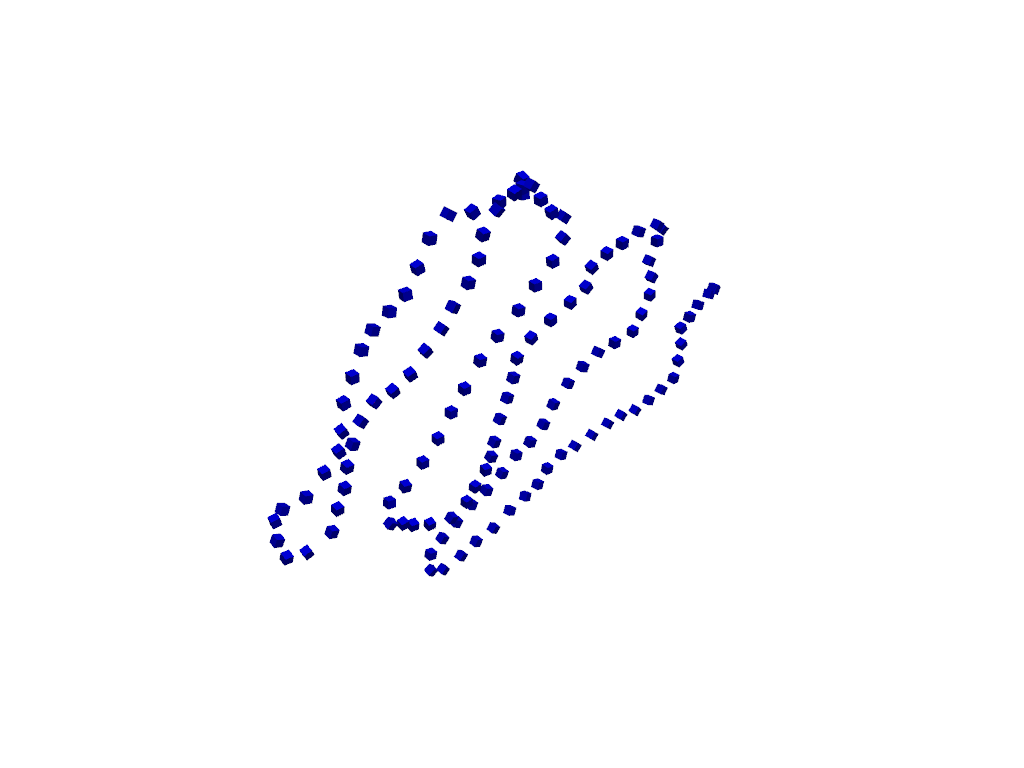

In [6]:
camera_set.vis()

/ofo-share/repos-eric/geograypher/geograypher/meshes/meshes.py:2042: RuntimeWarning: invalid value encountered in cast
  vis_scalars = np.clip(vis_scalars, 0, 255).astype(np.uint8)


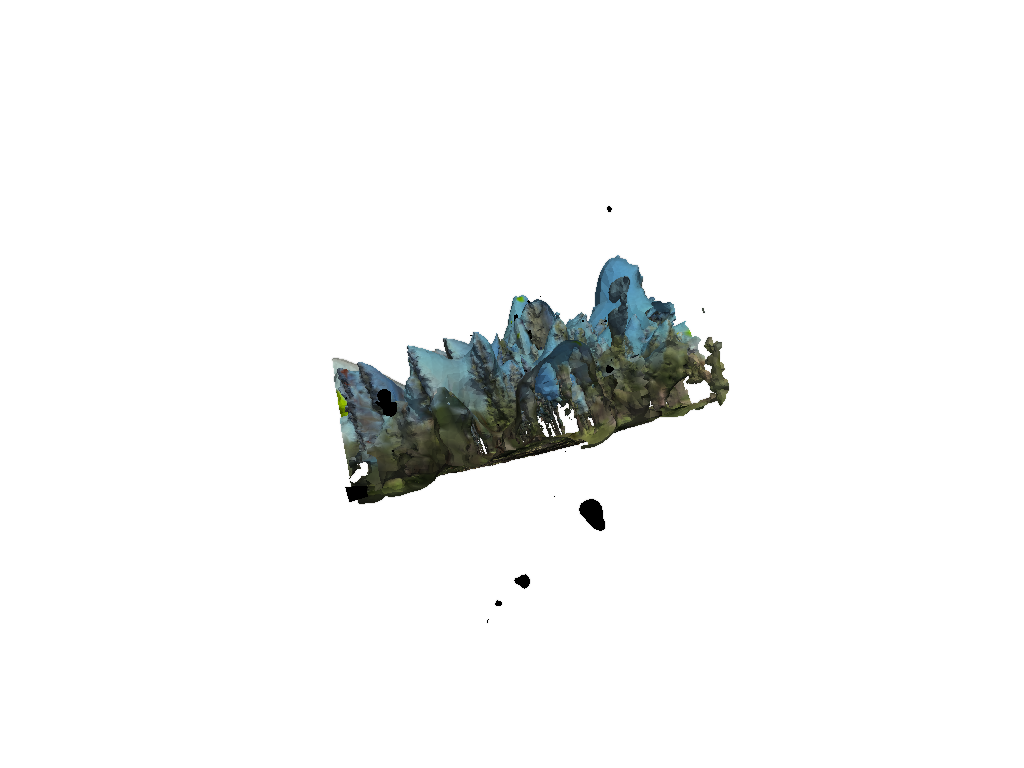

In [7]:
mesh.vis(camera_set=None, force_xvfb=True)

# Show the per-image predictions

Showing segmentation labels:   0%|          | 0/10 [00:00<?, ?it/s]

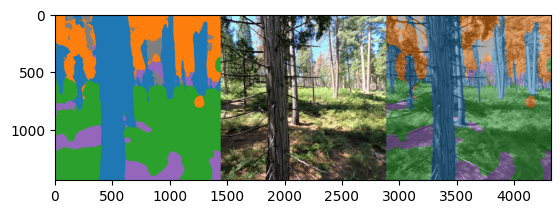

Showing segmentation labels:  10%|█         | 1/10 [00:01<00:09,  1.04s/it]

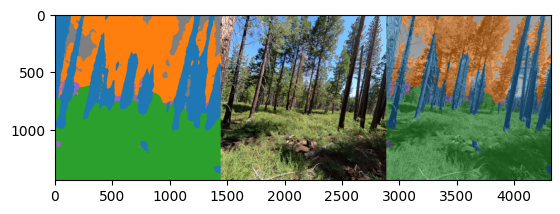

Showing segmentation labels:  20%|██        | 2/10 [00:02<00:08,  1.00s/it]

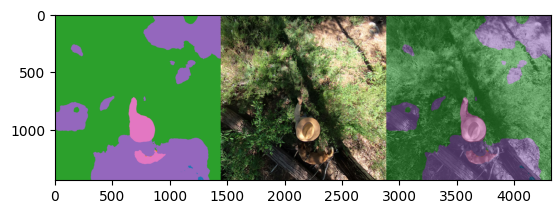

Showing segmentation labels:  30%|███       | 3/10 [00:02<00:06,  1.05it/s]

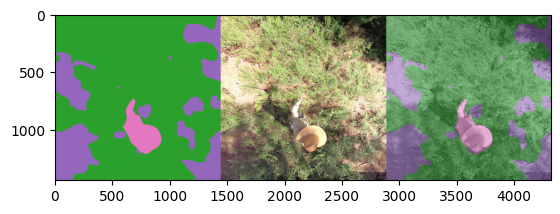

Showing segmentation labels:  40%|████      | 4/10 [00:03<00:05,  1.06it/s]

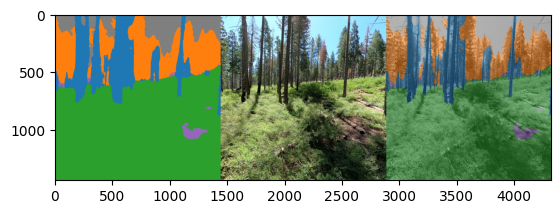

Showing segmentation labels:  50%|█████     | 5/10 [00:04<00:04,  1.07it/s]

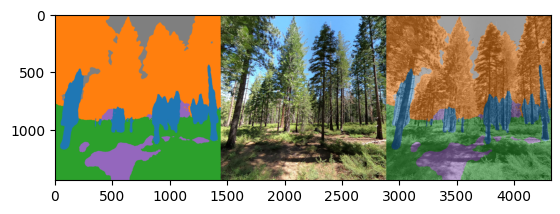

Showing segmentation labels:  60%|██████    | 6/10 [00:05<00:03,  1.07it/s]

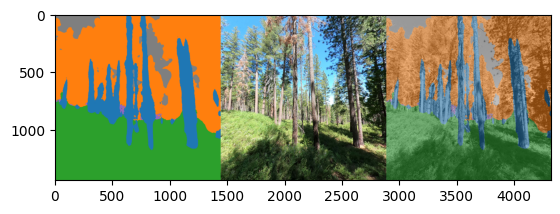

Showing segmentation labels:  70%|███████   | 7/10 [00:06<00:02,  1.05it/s]

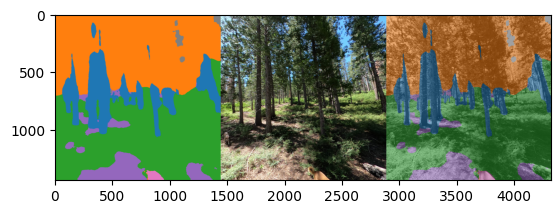

Showing segmentation labels:  80%|████████  | 8/10 [00:07<00:01,  1.06it/s]

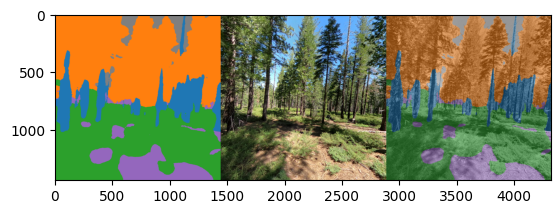

Showing segmentation labels:  90%|█████████ | 9/10 [00:08<00:00,  1.07it/s]

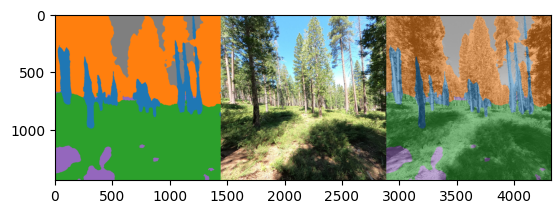

Showing segmentation labels: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


In [8]:
show_segmentation_labels(
    label_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    image_folder=IMAGE_FOLDER,
    IDs_to_labels=IDS_TO_LABELS,
    # NOTE: image suffix png is a temporary thing
    image_suffix=".png",
)

In [9]:
segmentor = LookUpSegmentor(
    base_folder=IMAGE_FOLDER,
    lookup_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    num_classes=len(mesh.get_label_names()),
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    camera_set, segmentor=segmentor
)

This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


In [10]:
if USE_CACHED_AGGREGATION and AGGREGATED_FACE_LABELS_FILE.is_file():
    aggregated_face_labels = np.load(AGGREGATED_FACE_LABELS_FILE)
else:
    aggregated_face_labels, _ = mesh.aggregate_projected_images(
        segmentor_camera_set,
        aggregate_img_scale=AGGREGATE_IMAGE_SCALE,
        apply_distortion=False,
    )
    np.save(AGGREGATED_FACE_LABELS_FILE, aggregated_face_labels)

Aggregating projected viewpoints: 100%|██████████| 756/756 [03:02<00:00,  4.13it/s]


In [11]:
predicted_face_classes = find_argmax_nonzero_value(aggregated_face_labels, keepdims=True)

# Handle the NaN predictions with nearest neighbors

In [ ]:
nbrs = NearestNeighbors(n_neighbors=3, algorithm="auto").fit(points)

# Show the projected and aggregated face predictions

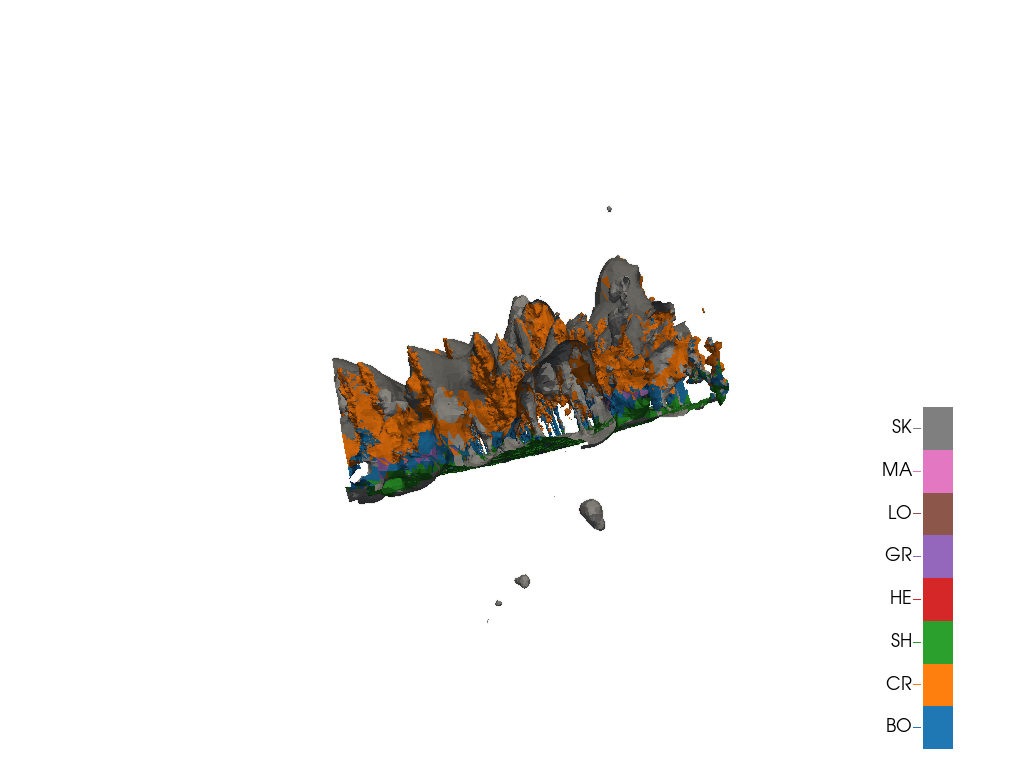

In [12]:
mesh.vis(vis_scalars=predicted_face_classes)

# Save the projected and aggregated face predictions as a mesh

In [13]:
pymesh = mesh.reproject_CRS(target_CRS=pyproj.CRS(26910), inplace=False)
pymesh.points -= np.array([763400, 4229800, 0])
assert pymesh.n_cells == len(predicted_face_classes)
del pymesh.point_data["RGB"]

colors = np.ones((pymesh.n_cells, 3))
cmap = plt.get_cmap("tab10")
for value in np.unique(predicted_face_classes):
    mask = predicted_face_classes.squeeze() == value
    colors[mask] = cmap(value / 10)[:3]
colors = (colors * 255).astype(np.uint8)

pymesh.cell_data["RGB"] = colors
pymesh.save(VIS_MESH_PATH, texture="RGB")